In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_v42 as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [5]:
def out2md_embeds(md, bst_trainerfp, bst_modelfp, embeds_out=None, out_file=None, verbose=False):
    def loadpkl(file):
        with open(file, 'rb') as f:
            data = pickle.load(f)
            f.close()
        return data
    trainer = loadpkl(bst_trainerfp)
    if verbose:
        total_t = time.time()
    dt = pd.DataFrame()
    embeds = pd.DataFrame()
    for split in ['train', 'test']: # omit val since test_pids contain val_pids (val is a subset of test)
        if verbose:
            tic = time.time()
            print('Starting inference for {} set...'.format(split))

        evaluation = weareval.eval_trained(trainer, split=split,
                                           modelpkl=bst_modelfp,
                                           two_outputs=True)
        dt = dt.append(pd.DataFrame({
            'y':evaluation.y.numpy(), 'yhat':evaluation.yhat.numpy(), 
            'split':[split]*evaluation.y.shape[0],
            'error':(evaluation.yhat - evaluation.y).numpy()
        }, index=evaluation.id))
        embeds = embeds.append(pd.DataFrame(evaluation.out2.numpy(), index=evaluation.id))
        if verbose:
            print('  inference for {} set done in {:.0f}-s\t{:.2f}-min elapsed'.format(split, time.time()-tic, (time.time()-total_t)/60))
    md = md.merge(dt, left_index=True, right_index=True, how='left')
    if out_file is not None:
        md.to_csv(out_file)
    if embeds_out is not None:
        embeds.to_csv(embeds_out)
    return md, embeds


def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)

In [3]:
# load data

pfp = '/home/ngrav/project/wearables/results/'
mfp = '/home/ngrav/project/wearables/model_zoo'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')
bst_modelembeds = os.path.join(pfp, 'embeds_v522_220124.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)
trainer = loadpkl(bst_trainer)

it = pd.read_csv(bst_modelembeds, index_col=0)

# model_fp = '/home/ngrav/scratch/wearables_model_zoo'

# trainer_fp = os.path.join(model_fp, 'trainer_itrandaug_GA4.pkl')
# modelpkl = os.path.join(model_fp, '752-itrandaug_GA4.pkl')

# if not os.path.exists(trainer_fp) and os.path.exists(modelpkl):
#     print('no pickles found along that path')

In [6]:
# gen random output and save
if True:
    rand_trainerfp = os.path.join(mfp, 'trainer_itrandv52_InceptionTime_GA5.pkl')
    rand_modelfp = os.path.join(mfp, '219-itrandv52_InceptionTime_GA5.pkl')
    mdrand, itrand = out2md_embeds(md, rand_trainerfp, rand_modelfp, 
                                   embeds_out=os.path.join(pfp, 'itrand_embds.csv'), 
                                   out_file=os.path.join(pfp, 'mdrand.csv'))

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [7]:
itrand.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
2256_24,0.781396,0.636621,1.150294,0.818668,0.791431,0.511001,0.720069,0.513961,0.714348,0.641154,...,1.115882,0.665938,0.657554,0.562206,1.182435,0.919141,0.144669,0.864647,1.263504,0.882550
1348_8,0.800295,0.648179,1.094258,0.842432,0.812804,0.497002,0.843573,0.463470,0.832104,0.606833,...,1.072422,0.691041,0.611612,0.520035,1.144223,0.880082,0.162141,0.913560,1.241781,0.937585
1144_28,1.748402,1.399086,0.678726,1.815749,1.764974,0.073746,0.943176,0.186707,0.922513,0.084536,...,0.623874,1.451824,0.329994,0.299942,0.756683,0.558074,0.224159,1.944928,0.901787,1.941935
1300_28,2.037184,1.651815,0.441930,2.116554,2.053873,0.002353,1.078129,0.056978,1.071656,0.001809,...,0.335878,1.699599,0.113863,0.106687,0.474253,0.303227,0.324485,2.196262,0.571235,2.207168
1716_7,0.833008,0.671592,0.893033,0.889140,0.858796,0.378188,1.083619,0.315183,1.030118,0.429057,...,0.938973,0.761172,0.493428,0.409695,1.024879,0.777041,0.232240,1.098523,1.226856,1.151438


# unsupervised

## fastdtw graph

1. D --> annoy --> clustering (unsupervised), then association with metadata
2. self-supervised embedding (~512dimensions) --> annoy based on D with various distance metrics OR DL based clustering, then association with metadata vs. GA association with metadata (otherwise, what is novel about the groups... do subclusters identify new interesting patients?)
3. 

In [9]:
# load previous
load = True

if load:
    # load it 
    with open('/home/ngrav/scratch/data_dtw.pkl', 'rb') as f:
        data_dtw = pickle.load(f)
        f.close()
else:
    # run it
    data_dtw = weardtw.rawdata_umap_dtw(trainer_fp) #

    # since this takes so long, save it
    with open('/home/ngrav/scratch/data_dtw.pkl', 'wb') as f:
        pickle.dump(data_dtw, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

In [10]:
# rerun umap, forgot to return data
data_dtw['data_umap'] = weardtw.embed(data_dtw['D'])

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [11]:
dtwumap = data_dtw['data_umap']
mddtw = data_dtw['md']

In [18]:
mddtw = mddtw.merge(md.loc[:, [col for col in md.columns if col not in mddtw.columns]], left_index=True, right_index=True, how='left')

In [232]:
# # add model output 
# md = md.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
# md['AbsErr'] = np.abs(md['GA'] - md['actigraphy-GA'])
# md['actigraphyGA-GA'] = md['actigraphy-GA'] - md['GA']

In [22]:
savefigs = True

In [20]:
D = data_dtw['D']
membership = weardtw.leiden_clustering(D, gamma=0.5)
mddtw['leiden'] = membership

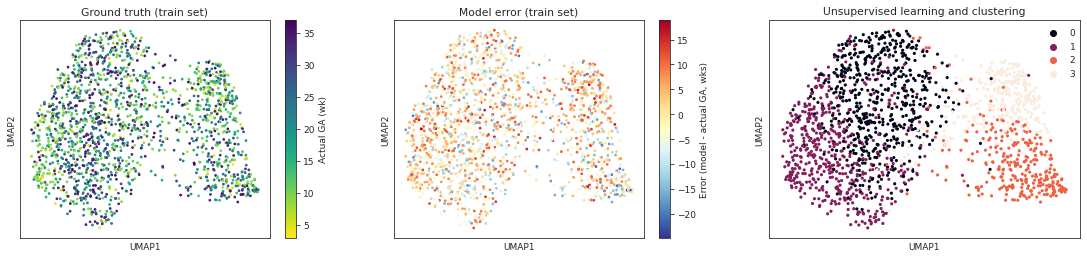

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
# ground truth
im = ax[0].scatter(dtwumap[:, 0], dtwumap[:, 1], 
                s=3,
                c=mddtw['GA'], cmap='viridis_r')
fig.colorbar(im, label='Actual GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(dtwumap[:, 0], dtwumap[:, 1], 
                s=3,
                c=mddtw['error'], cmap='RdYlBu_r')
fig.colorbar(im, label='Error (model - actual GA, wks)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('Model error (train set)')

sns.scatterplot(x=dtwumap[:, 0], 
                y=dtwumap[:, 1], 
                s=10,
                hue=mddtw['leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Unsupervised learning and clustering')
if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_DTW_leiden_v522.pdf'), bbox_inches='tight', dpi=600)

# bst model

### compare to model embeddings

can always improve upon, extract embedding output, and merge with metadata for viz

**NOTE**: need to optimize the metric selected (after pipeline for cluster annotation)

In [26]:
# md_model = md_model.loc[evaluation.id, :] # re-order to match output
# md_model = md_model.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
# md_model['AbsErr'] = np.abs(md_model['GA'] - md_model['actigraphy-GA'])
# md_model['actigraphyGA-GA'] = md_model['actigraphy-GA'] - md_model['GA'] 

In [30]:
itumap = weardtw.embed(it.to_numpy(), metric='manhattan')

In [31]:
from scipy.spatial.distance import pdist, squareform
D_model = squareform(pdist(it.to_numpy(), metric='cityblock'))
membership_model = weardtw.leiden_clustering(D_model, gamma=0.5)


In [34]:
# add clusters to md
md.loc[it.index, 'model_leiden'] = membership_model

In [88]:
idxs = {i:idx for i, idx in enumerate(it.index) if idx in md.loc[md['split']=='train'].index.to_list()}
xy = itumap[list(idxs.keys()), :]
dt = md.loc[list(idxs.values())]

In [89]:
savefigs = False

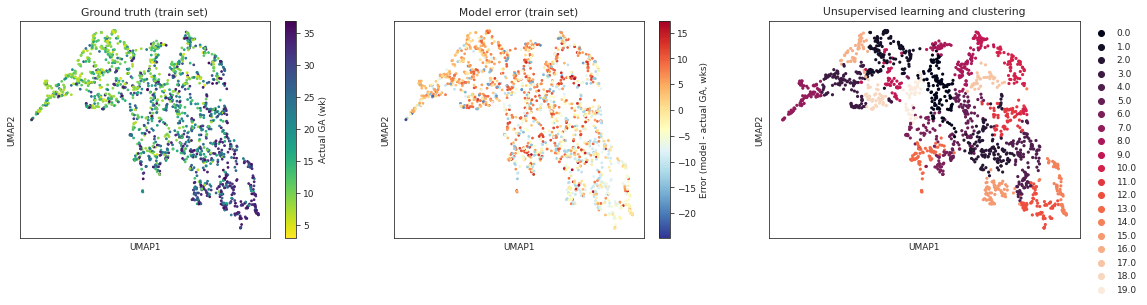

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
# ground truth
im = ax[0].scatter(itumap[list(idxs.keys()), 0], 
                   itumap[list(idxs.keys()), 1], 
                s=3,
                c=md.loc[list(idxs.values()), 'GA'], 
                   cmap='viridis_r')
fig.colorbar(im, label='Actual GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(itumap[list(idxs.keys()), 0], 
                   itumap[list(idxs.keys()), 1],
                s=3,
                c=md.loc[list(idxs.values()), 'error'], cmap='RdYlBu_r')
fig.colorbar(im, label='Error (model - actual GA, wks)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('Model error (train set)')

sns.scatterplot(x=itumap[list(idxs.keys()), 0], 
                y=itumap[list(idxs.keys()), 1], 
                s=10,
                hue=md.loc[list(idxs.values()), 'model_leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Unsupervised learning and clustering')

if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_ITbst_leiden_v522.pdf'), bbox_inches='tight', dpi=600)

In [100]:
savefigs = True

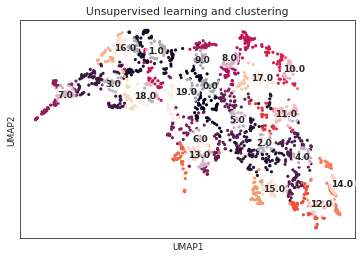

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(x=xy[:, 0], 
                y=xy[:, 1], 
                s=10,
                hue=dt['model_leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Unsupervised learning and clustering')
ax.legend().set_visible(False)

for c in dt['model_leiden'].unique():
    xyprime = np.mean(xy[np.where(dt['model_leiden']==c)[0], :], 0)
    ax.text(*xyprime, str(c), bbox=dict(boxstyle='circle', fc="w", ec="none", alpha=0.66), weight='bold')
    

if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_ITbst_leiden_v522_annotated.pdf'), bbox_inches='tight', dpi=600)

## random clustering

In [58]:
# md_model = md.loc[evaluation.id, :]
itrandumap = weardtw.embed(itrand.to_numpy(), metric='manhattan')

In [56]:
# # add model output 
# md_random = md_random.loc[evaluation.id, :] # reorder
# md_random = md_random.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
# md_random['AbsErr'] = np.abs(md_random['GA'] - md_random['actigraphy-GA'])

In [59]:
# cluster
from scipy.spatial.distance import pdist, squareform
D_random = squareform(pdist(itrand.to_numpy(), metric='cityblock'))
member_random = weardtw.leiden_clustering(D_random, gamma=0.5)
md.loc[itrand.index, 'rand_leiden'] = member_random

In [60]:
idxs = {i:idx for i, idx in enumerate(itrand.index) if idx in md.loc[md['split']=='train'].index.to_list()}

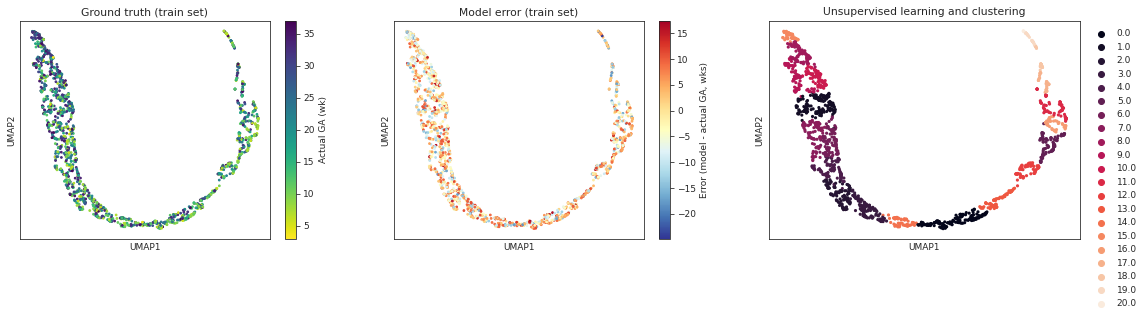

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
# ground truth
im = ax[0].scatter(itrandumap[list(idxs.keys()), 0], 
                   itrandumap[list(idxs.keys()), 1], 
                s=3,
                c=md.loc[list(idxs.values()), 'GA'], 
                   cmap='viridis_r')
fig.colorbar(im, label='Actual GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(itrandumap[list(idxs.keys()), 0], 
                   itrandumap[list(idxs.keys()), 1],
                s=3,
                c=md.loc[list(idxs.values()), 'error'], cmap='RdYlBu_r')
fig.colorbar(im, label='Error (model - actual GA, wks)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('Model error (train set)')

sns.scatterplot(x=itrandumap[list(idxs.keys()), 0], 
                y=itrandumap[list(idxs.keys()), 1], 
                s=10,
                hue=md.loc[list(idxs.values()), 'rand_leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Unsupervised learning and clustering')

if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_ITrand_leiden_v522.pdf'), bbox_inches='tight', dpi=600)

In [107]:
idxs = {i:idx for i, idx in enumerate(itrand.index) if idx in md.loc[md['split']=='train'].index.to_list()}
xy = itrandumap[list(idxs.keys()), :]
dt = md.loc[list(idxs.values())]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(x=xy[:, 0], 
                y=xy[:, 1], 
                s=10,
                hue=dt['model_leiden'],
                palette={c:'k' if c !=17 else 'r' for c in dt['},
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Unsupervised learning and clu

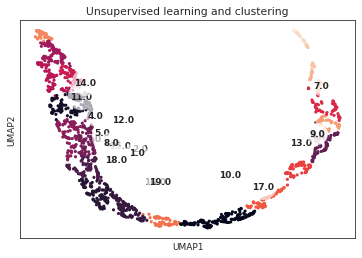

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(x=xy[:, 0], 
                y=xy[:, 1], 
                s=10,
                hue=dt['rand_leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Unsupervised learning and clustering')
ax.legend().set_visible(False)

for c in dt['model_leiden'].unique():
    xyprime = np.mean(xy[np.where(dt['model_leiden']==c)[0], :], 0)
    ax.text(*xyprime, str(c), bbox=dict(boxstyle='circle', fc="w", ec="none", alpha=0.66), weight='bold')
    


# cluster analysis

Place clusters in metadata df and analyze for differences

*data*: 
- `md`: from unsupervised DTW embedding
- `md_model`: from model embeddings
- `md_random`: from random model embeddings (label shuffling)

In [69]:
from wearables.scripts.md_specification import mdpred_voi
from sklearn.metrics.cluster import contingency_matrix

In [72]:
def sigvars_per_cluster(metadata, voi, cluster_key='leiden', bonferonni_crct=True, verbose=True):
    '''Exclusive significance in cluster that is enriched categorically or has log2FC average >=0.5.'''
    def pval2sigvarlist(res, p_cutoff=0.001 / len(voi.keys()) if bonferonni_crct else 0.001, min_l2fc=0.5):
        filtered_res = {k:[] for k in res.keys()}
        for cid in res.keys():
            other_cids = [i for i in res.keys() if i!=cid]
            for var, val in res[cid].items():
                if (val[0] <= p_cutoff and not any([True if res[k][var][0] <= p_cutoff else False for k in other_cids])) and (isinstance(val[1], np.float32) and np.abs(val[1]) >= min_l2fc):
                    filtered_res[cid].append({'name': '{}_l2fc(c-rest)={:.2f}'.format(var, val[1]),
                                              'P_adj': val[0] / len(voi.keys()) if bonferonni_crct else val[0], 'log2fc(c-rest)': val[1]})
                elif (val[0] <= p_cutoff and not any([True if res[k][var][0] <= p_cutoff else False for k in other_cids])) and (isinstance(val[1], pd.DataFrame) and np.unravel_index(np.argmax(val[1].abs()), val[1].shape)[1] == 1):
                    idx = np.unravel_index(np.argmax(val[1].abs()), val[1].shape)
                    filtered_res[cid].append({'name': '{}={} enriched by {:.2f}-%'.format(var, val[1].index[idx[0]], 100*val[1].iloc[idx]),
                                         'P_adj': val[0] / len(voi.keys()) if bonferonni_crct else val[0], 'obs/exp-1': val[1]})
        return filtered_res
    from scipy.stats import chi2_contingency
    from scipy.stats import kruskal
    results = {c:{} for c in np.sort(metadata[cluster_key].unique())}
    # one-vs-rest scheme
    for i, c in enumerate(np.sort(metadata[cluster_key].unique())):
        metadata['cluster_part'] = (metadata[cluster_key] == c)
        for ii, v in enumerate(voi.keys()):
            if voi[v] == 'continuous':
                v_c = metadata.loc[metadata[cluster_key]==c, v]
                v_notc = metadata.loc[metadata[cluster_key]!=c, v]
                statistic, p = kruskal(v_c, v_notc)
                metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC
                metric = np.float32(metric)
            else:
                obs = metadata.groupby([v, 'cluster_part']).size().unstack(fill_value=0)
                chi2, p, dof, expected = chi2_contingency(obs) # Fischer's?
                metric = ((obs / expected) - 1) # obs/expected ratio
            results[c][v] = ( p, metric )
    out = pval2sigvarlist(results)
    if verbose:
        for k in np.sort(list(out.keys())):
            for v in out[k]:
                print('cluster_id: {}, annotation: {}'.format(k, v['name'])) 
    return out

In [76]:
dtw_clustanal = sigvars_per_cluster(mddtw, mdpred_voi)
# rand_clustanal = sigvars_per_cluster(md_random, voi)

/tmp/ipykernel_1453818/1782148115.py:27: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 1, annotation: work_hrs1=0.0 enriched by -33.33-%
cluster_id: 2, annotation: drugs=2.0 enriched by 89.20-%
cluster_id: 2, annotation: income_annual1=1.0 enriched by 59.21-%
cluster_id: 2, annotation: stress3_1=0.0 enriched by 64.53-%
cluster_id: 3, annotation: stress1_1=0.0 enriched by 102.57-%
cluster_id: 3, annotation: stress6_1=0.0 enriched by 108.27-%
cluster_id: 3, annotation: stress9_1=0.0 enriched by 99.59-%
cluster_id: 3, annotation: workreg_1trim=0.0 enriched by 99.87-%
cluster_id: 3, annotation: choosesleep_1trim=0.0 enriched by 112.44-%
cluster_id: 3, annotation: slpwake_1trim=0.0 enriched by 107.72-%
cluster_id: 3, annotation: slp30_1trim=0.0 enriched by 107.72-%
cluster_id: 3, annotation: sleep_qual1=0.0 enriched by 107.72-%
cluster_id: 3, annotation: sitting1=0.0 enriched by 106.07-%
cluster_id: 3, annotation: tv1=0.0 enriched by 106.07-%
cluster_id: 3, annotation: inactive1=0.0 enriched by 106.07-%
cluster_id: 3, annotation: passenger1=0.0 enriched by 106.07-

In [79]:
model_clustanal = sigvars_per_cluster(md.loc[md['split']=='train'], mdpred_voi, cluster_key='model_leiden')

/tmp/ipykernel_1453818/1782148115.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['cluster_part'] = (metadata[cluster_key] == c)
/tmp/ipykernel_1453818/1782148115.py:27: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 3.0, annotation: alcohol=2.0 enriched by 211.83-%
cluster_id: 3.0, annotation: smoke=2.0 enriched by 190.33-%
cluster_id: 3.0, annotation: drugs=2.0 enriched by 192.34-%
cluster_id: 3.0, annotation: deliv_mode=3.0 enriched by 191.24-%
cluster_id: 3.0, annotation: premature_birth1=0.0 enriched by 105.81-%
cluster_id: 3.0, annotation: stress2_1=0.0 enriched by 204.32-%
cluster_id: 3.0, annotation: stress3_1=0.0 enriched by 204.32-%
cluster_id: 3.0, annotation: stress4_1=0.0 enriched by 204.32-%
cluster_id: 3.0, annotation: stress6_1=0.0 enriched by 217.40-%
cluster_id: 3.0, annotation: stress8_1=0.0 enriched by 204.32-%
cluster_id: 3.0, annotation: workreg_1trim=0.0 enriched by 140.28-%
cluster_id: 3.0, annotation: choosesleep_1trim=0.0 enriched by 129.10-%
cluster_id: 9.0, annotation: abuse=1.0 enriched by 495.17-%
cluster_id: 9.0, annotation: income_annual1=1.0 enriched by 104.40-%
cluster_id: 9.0, annotation: afterlunch1=0.0 enriched by 121.88-%
cluster_id: 9.0, annotation

In [80]:
rand_clustanal = sigvars_per_cluster(md.loc[md['split']=='train'], mdpred_voi, cluster_key='rand_leiden')

/tmp/ipykernel_1453818/1782148115.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['cluster_part'] = (metadata[cluster_key] == c)
/tmp/ipykernel_1453818/1782148115.py:27: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 4.0, annotation: marital=1.0 enriched by 51.93-%
cluster_id: 10.0, annotation: race=0.0 enriched by 64.70-%
cluster_id: 10.0, annotation: education=1.0 enriched by -100.00-%
cluster_id: 10.0, annotation: paidjob1=0.0 enriched by -80.61-%
cluster_id: 10.0, annotation: work_hrs1=4.0 enriched by 88.06-%
cluster_id: 13.0, annotation: surghx_none=0.0 enriched by 56.58-%
cluster_id: 17.0, annotation: edinb9_1trim=0.0 enriched by 617.67-%
cluster_id: 17.0, annotation: edinb10_1trim=3.0 enriched by 774.66-%


In [105]:
# save all results
cluster_annotation = {
    'itumap': pd.DataFrame(it, index=it.index.to_list()),
    'itrandumap': pd.DataFrame(itrand, index=itrand.index.to_list()),
    'dtwumap': pd.DataFrame(dtwumap, index=mddtw.index.to_list()),
    'md_model_rand': md,
    'md_dtw': mddtw,
    'dtw_cluster_annotation': dtw_clustanal,
    'model_cluster_annotation': model_clustanal,
    'rand_cluster_annotation': rand_clustanal,
}
with open(os.path.join(pfp, 'model_embeds_clustannotation.pkl'), 'wb') as f:
    pickle.dump(cluster_annotation, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


# predictability of model embeddings

Show that they're more useful than kNN/TSRF/LightGBM on actigraphy

In [ ]:
# store